<a href="https://colab.research.google.com/github/revs1/Model-Interpretation-using-SHAP/blob/master/VGG16_model_interpretation_using_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install shap

     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394130 sha256=80ea21689e99cd8a51e3c6319754729edde0bdca5c121c7ced603139bc175dca
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [6]:
pip install 'keras==2.2.0'

     |████████████████████████████████| 307kB 2.8MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
ERROR: tensorflow 1.12.0 has requirement keras-applications>=1.0.6, but you'll have keras-applications 1.0.2 which is incompatible.
ERROR: tensorflow 1.12.0 has requirement keras-preprocessing>=1.0.5, but you'll have keras-preprocessing 1.0.1 which is incompatible.
  Found existing installation: Keras-Applications 1.0.8
    Uninstalling Keras-Applications-1.0.8:
      Successfully uninstalled Keras-Applications-1.0.8
  Found existing installation: Keras-Preprocessing 1.1.0
    Uninstalling Keras-Preprocessing-1.1.0:
      Successfully uninstalled Keras-Preprocessing-1.1.0
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [1]:
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import shap
from tensorflow.keras import backend as K
#import keras.backend as K
import json
shap.initjs()


def visualize_model_decisions(shap_values, x, labels=None, figsize=(20, 30)):
    
    colors = []
    for l in np.linspace(1, 0, 100):
        colors.append((30./255, 136./255, 229./255,l))
    for l in np.linspace(0, 1, 100):
        colors.append((255./255, 13./255, 87./255,l))
    red_transparent_blue = LinearSegmentedColormap.from_list("red_transparent_blue", colors)

    multi_output = True
    if type(shap_values) != list:
        multi_output = False
        shap_values = [shap_values]

    # make sure labels
    if labels is not None:
        assert labels.shape[0] == shap_values[0].shape[0], "Labels must have same row count as shap_values arrays!"
        if multi_output:
            assert labels.shape[1] == len(shap_values), "Labels must have a column for each output in shap_values!"
        else:
            assert len(labels.shape) == 1, "Labels must be a vector for single output shap_values."

    # plot our explanations
    fig_size = figsize
    fig, axes = plt.subplots(nrows=x.shape[0], ncols=len(shap_values) + 1, figsize=fig_size)
    if len(axes.shape) == 1:
        axes = axes.reshape(1,axes.size)
    for row in range(x.shape[0]):
        x_curr = x[row].copy()

        # make sure
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 1:
            x_curr = x_curr.reshape(x_curr.shape[:2])
        if x_curr.max() > 1:
            x_curr /= 255.
        
        axes[row,0].imshow(x_curr)
        axes[row,0].axis('off')
        
        # get a grayscale version of the image
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 3:
            x_curr_gray = (0.2989 * x_curr[:,:,0] + 0.5870 * x_curr[:,:,1] + 0.1140 * x_curr[:,:,2]) # rgb to gray
        else:
            x_curr_gray = x_curr

        if len(shap_values[0][row].shape) == 2:
            abs_vals = np.stack([np.abs(shap_values[i]) for i in range(len(shap_values))], 0).flatten()
        else:
            abs_vals = np.stack([np.abs(shap_values[i].sum(-1)) for i in range(len(shap_values))], 0).flatten()
        max_val = np.nanpercentile(abs_vals, 99.9)
        for i in range(len(shap_values)):
            if labels is not None:
                axes[row,i+1].set_title(labels[row,i])
            sv = shap_values[i][row] if len(shap_values[i][row].shape) == 2 else shap_values[i][row].sum(-1)
            axes[row,i+1].imshow(x_curr_gray, cmap=plt.get_cmap('gray'), alpha=0.15, extent=(-1, sv.shape[0], sv.shape[1], -1))
            im = axes[row,i+1].imshow(sv, cmap=red_transparent_blue, vmin=-max_val, vmax=max_val)
            axes[row,i+1].axis('off')
        
    cb = fig.colorbar(im, ax=np.ravel(axes).tolist(), label="SHAP value", orientation="horizontal", aspect=fig_size[0]/0.2)
    cb.outline.set_visible(False)


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

In [2]:
model = VGG16(weights='imagenet', include_top=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
X, y = shap.datasets.imagenet50()
len(X), len(y)

(50, 50)

In [0]:
IMAGE_PATH = '/content/cat.png'
img = keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = keras.preprocessing.image.img_to_array(img)

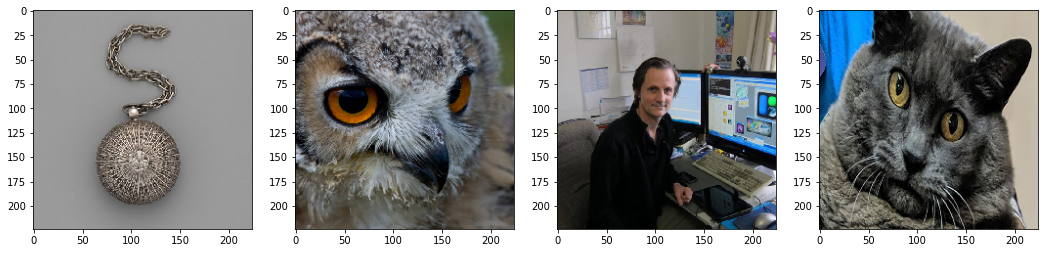

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

to_predict = np.array([X[28], X[35], X[46], img])
fig, ax = plt.subplots(1, 4, figsize=(18, 10))
ax[0].imshow(to_predict[0]/255.)
ax[1].imshow(to_predict[1]/255.)
ax[2].imshow(to_predict[2]/255.)
ax[3].imshow(to_predict[3]/255.)

In [0]:
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

In [7]:
predictions = model.predict(preprocess_input(to_predict.copy()))
predictions, predictions.shape

(array([[2.1085035e-07, 6.7834321e-07, 1.5247693e-06, ..., 1.3814143e-05,
         2.5486994e-05, 3.4056779e-05],
        [1.4483965e-12, 3.2981454e-11, 7.7344184e-14, ..., 5.6721563e-12,
         6.6913008e-09, 4.7253389e-11],
        [1.8191190e-07, 1.7580463e-07, 2.2195713e-06, ..., 1.7119961e-08,
         4.5716361e-06, 2.3215232e-06],
        [4.4576649e-09, 2.2521522e-08, 6.3754895e-09, ..., 3.0157583e-09,
         3.8207768e-06, 1.6151903e-04]], dtype=float32), (4, 1000))

In [12]:
predicted_labels = [class_names.get(str(pred)) for pred in np.argmax(predictions, axis=1)]
print(predicted_labels)

[['n02999410', 'chain'], ['n01622779', 'great_grey_owl'], ['n03180011', 'desktop_computer'], ['n02124075', 'Egyptian_cat']]


In [0]:
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

In [9]:
model.layers[7].input

<tf.Tensor 'block2_pool/MaxPool:0' shape=(?, 56, 56, 128) dtype=float32>

In [16]:

import tensorflow as tf
print(tf.__version__)

1.12.0


In [17]:
pip install --user --upgrade tensorflow-probability

Requirement already up-to-date: tensorflow-probability in /usr/local/lib/python3.6/dist-packages (0.10.0rc0)


In [23]:

e = shap.GradientExplainer((model.layers[7].input, model.layers[-1].output)
                           ,map2layer(preprocess_input(X.copy()), 7) ,local_smoothing=100)
shap_values, indexes = e.shap_values(map2layer(to_predict, 7), ranked_outputs=2)
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
index_names

array([['chain', 'chain_mail'],
       ['great_grey_owl', 'prairie_chicken'],
       ['desktop_computer', 'screen'],
       ['Egyptian_cat', 'tabby']], dtype='<U16')

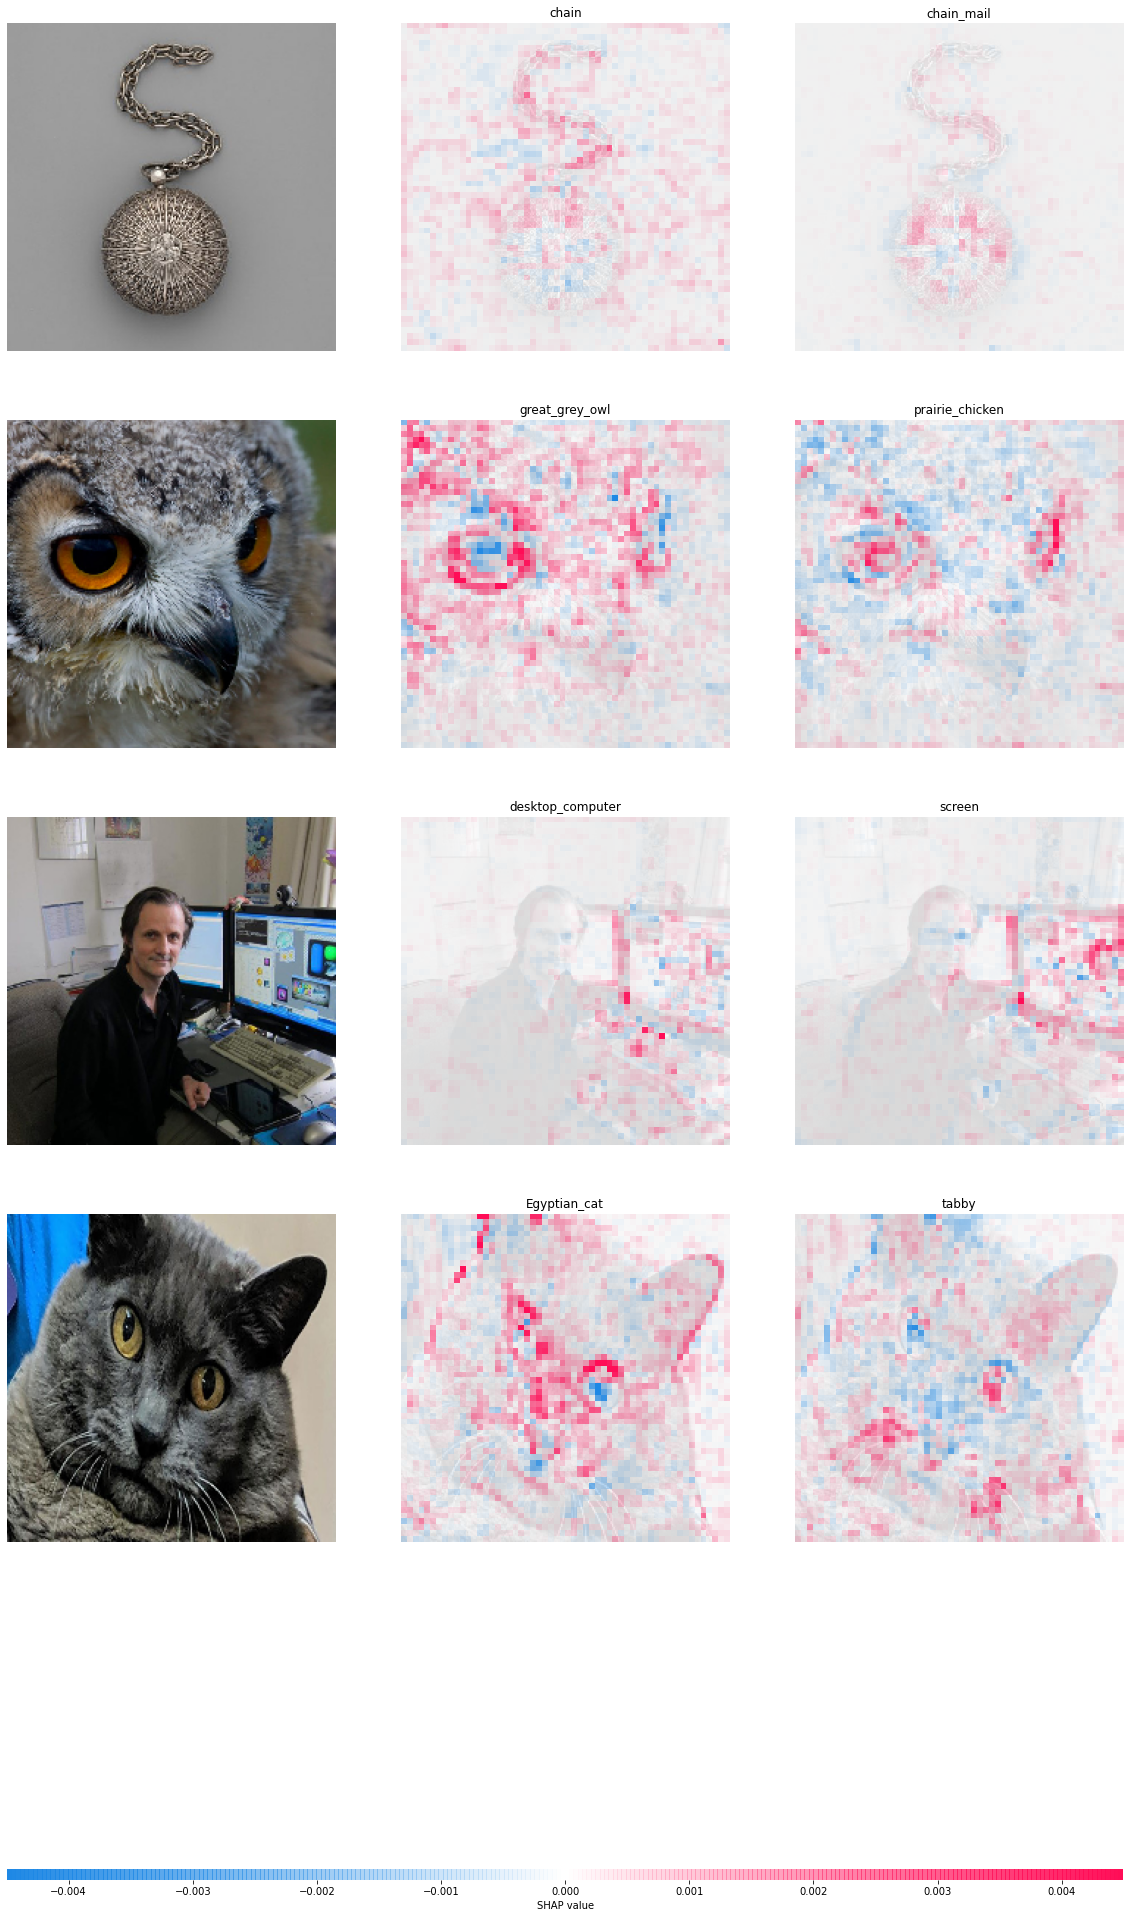

In [24]:
visualize_model_decisions(shap_values=shap_values, x=to_predict, 
                          labels=index_names, figsize=(20, 40))

In [25]:
model.layers[14].input

<tf.Tensor 'block4_conv3/Relu:0' shape=(?, 28, 28, 512) dtype=float32>

In [26]:

e = shap.GradientExplainer((model.layers[14].input, model.layers[-1].output), 
                            map2layer(preprocess_input(X.copy()), 14))
shap_values, indexes = e.shap_values(map2layer(to_predict, 14), ranked_outputs=2)
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
index_names

array([['chain', 'chain_mail'],
       ['great_grey_owl', 'prairie_chicken'],
       ['desktop_computer', 'screen'],
       ['Egyptian_cat', 'tabby']], dtype='<U16')

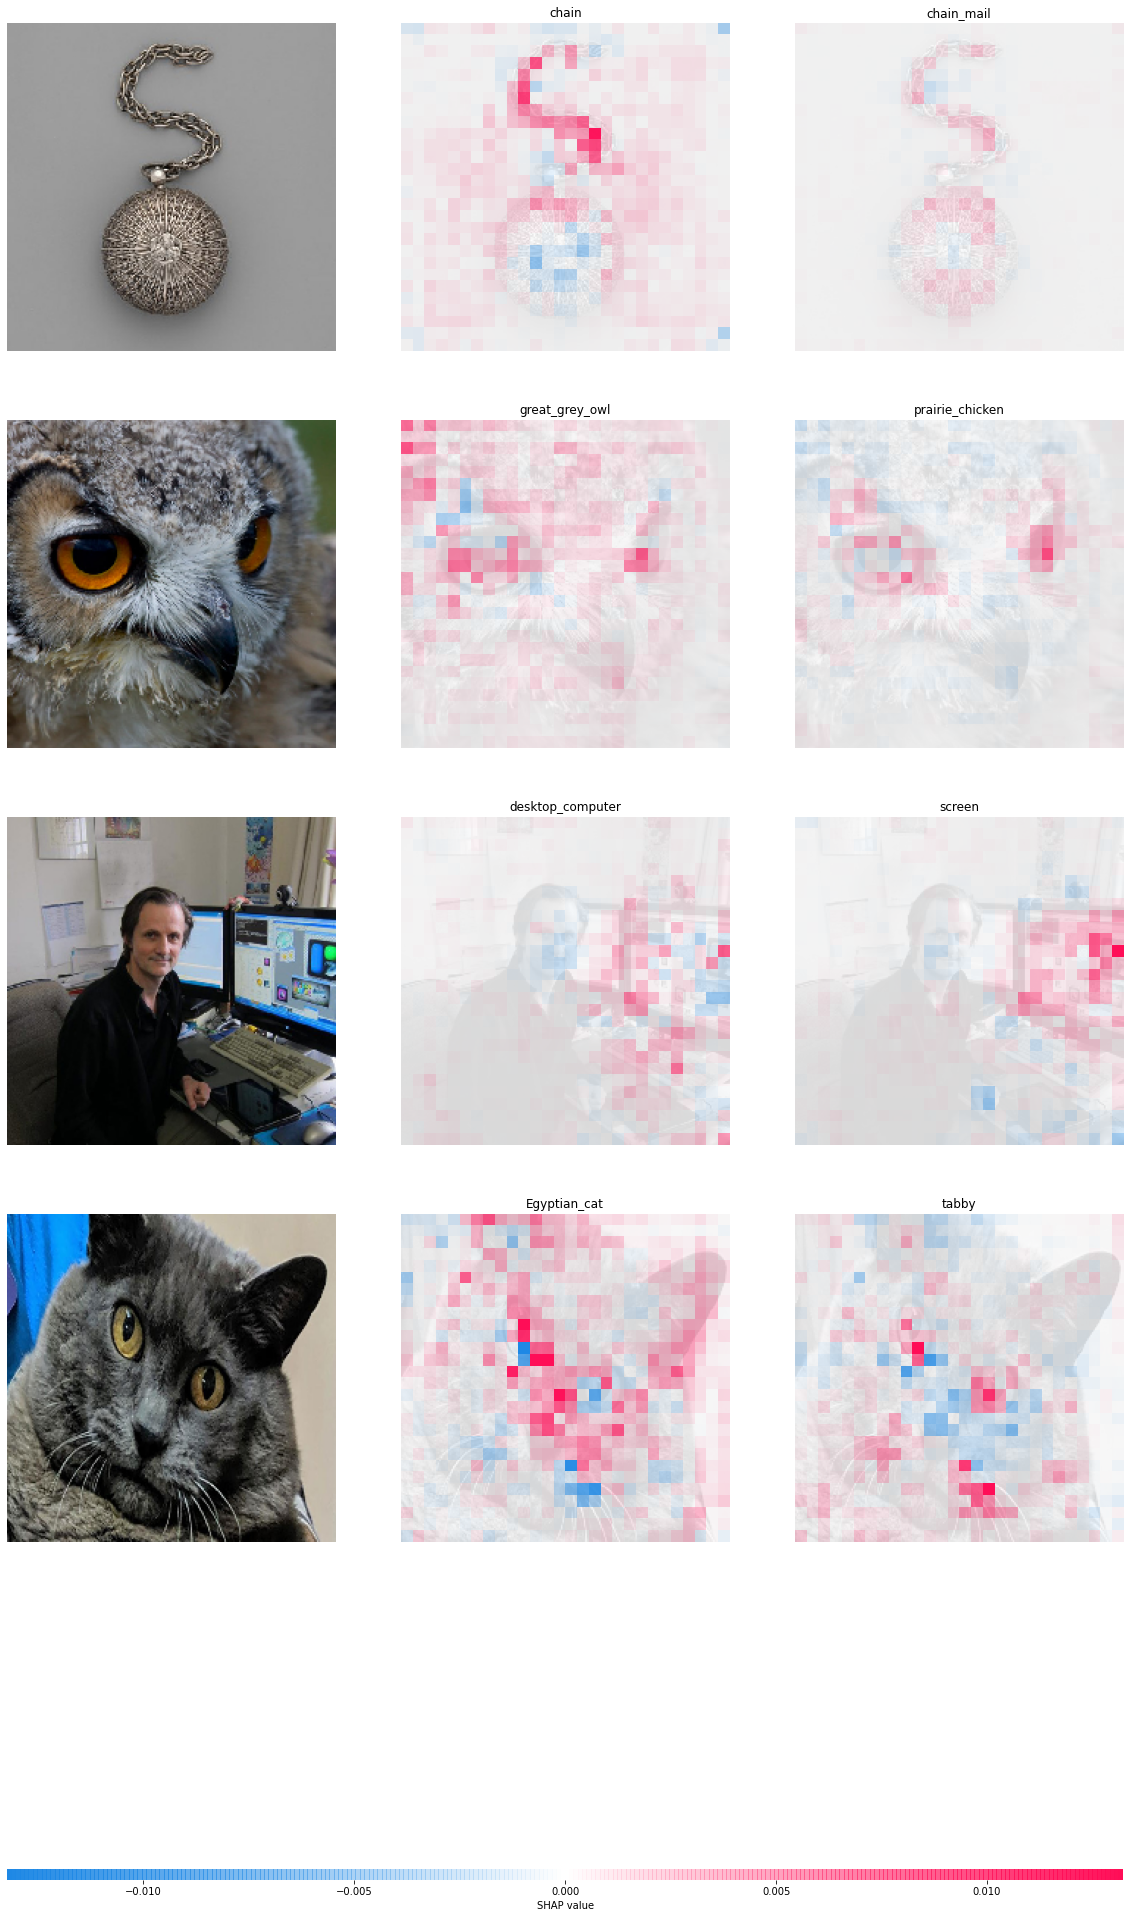

In [27]:
visualize_model_decisions(shap_values=shap_values, x=to_predict, 
                          labels=index_names, figsize=(20, 40))

In [29]:
model.layers[5].input

<tf.Tensor 'block2_conv1/Relu:0' shape=(?, 112, 112, 128) dtype=float32>

In [31]:

e = shap.GradientExplainer((model.layers[5].input, model.layers[-1].output), 
                            map2layer(preprocess_input(X.copy()), 5))
shap_values, indexes = e.shap_values(map2layer(to_predict, 5), ranked_outputs=2)
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
index_names

array([['chain', 'chain_mail'],
       ['great_grey_owl', 'prairie_chicken'],
       ['desktop_computer', 'screen'],
       ['Egyptian_cat', 'tabby']], dtype='<U16')

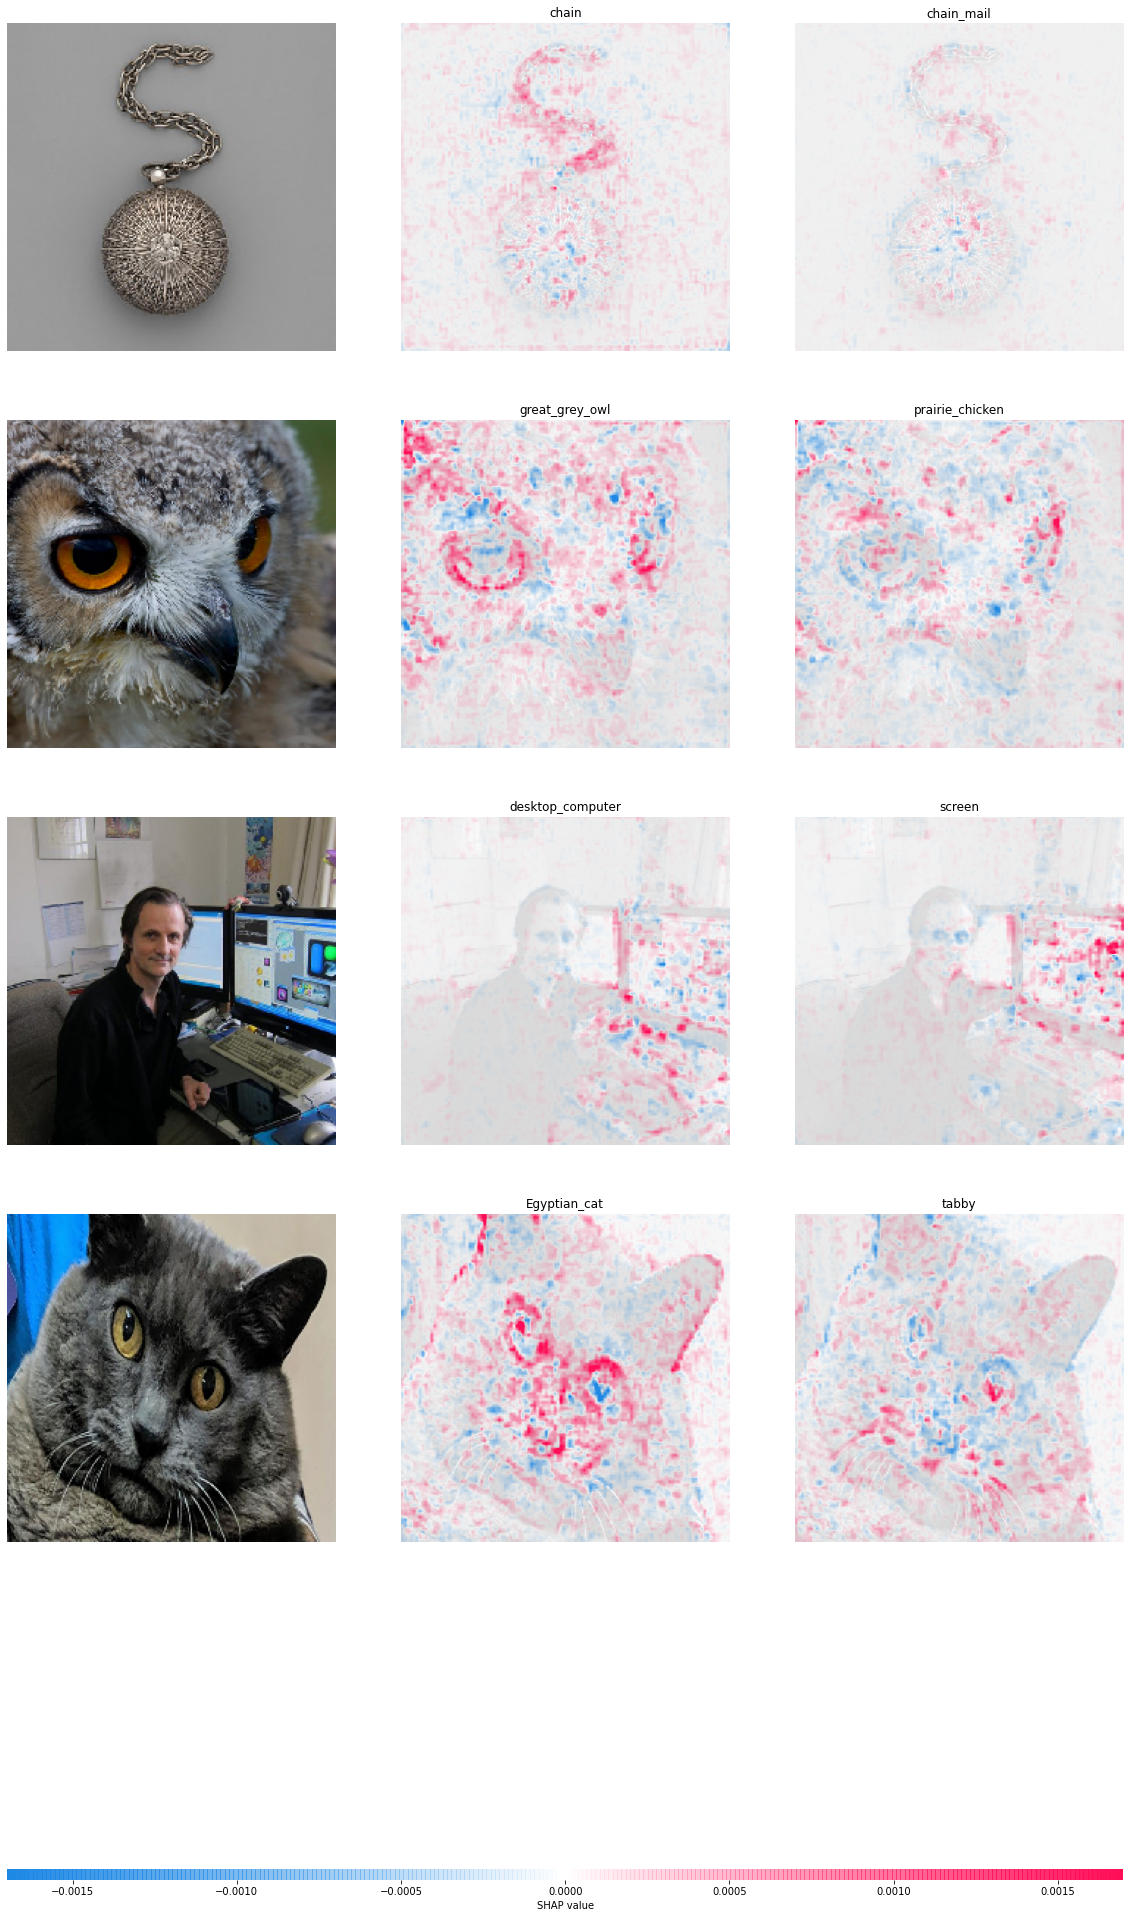

In [32]:
visualize_model_decisions(shap_values=shap_values, x=to_predict, 
                          labels=index_names, figsize=(20, 40))